In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csiro-biomass/sample_submission.csv
/kaggle/input/csiro-biomass/train.csv
/kaggle/input/csiro-biomass/test.csv
/kaggle/input/csiro-biomass/test/ID1001187975.jpg
/kaggle/input/csiro-biomass/train/ID2099464826.jpg
/kaggle/input/csiro-biomass/train/ID2037861084.jpg
/kaggle/input/csiro-biomass/train/ID1211362607.jpg
/kaggle/input/csiro-biomass/train/ID1853508321.jpg
/kaggle/input/csiro-biomass/train/ID193102215.jpg
/kaggle/input/csiro-biomass/train/ID698608346.jpg
/kaggle/input/csiro-biomass/train/ID1859251563.jpg
/kaggle/input/csiro-biomass/train/ID1880764911.jpg
/kaggle/input/csiro-biomass/train/ID853954911.jpg
/kaggle/input/csiro-biomass/train/ID1403107574.jpg
/kaggle/input/csiro-biomass/train/ID1781353117.jpg
/kaggle/input/csiro-biomass/train/ID384648061.jpg
/kaggle/input/csiro-biomass/train/ID1563418511.jpg
/kaggle/input/csiro-biomass/train/ID2125100696.jpg
/kaggle/input/csiro-biomass/train/ID482555369.jpg
/kaggle/input/csiro-biomass/train/ID638711343.jpg
/kaggle/input/c

In [37]:
import torch
print(torch.cuda.memory_reserved() / 1024**3, "GB reserved")
print(torch.cuda.memory_allocated() / 1024**3, "GB allocated")


2.607421875 GB reserved
0.984461784362793 GB allocated


In [38]:

import os, gc, copy
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error#to compare r2
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Config
class CFG:
    seed = 42
    img_size = 224           
    batch_size = 16           
    epochs = 15       #ran on sample of 15 but results were better if the no of epochs was increased       
    n_folds = 5
    num_workers = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    swin_model_name = "swin_tiny_patch4_window7_224"
    effnet_model_name = "efficientnet_b1"

    lr = 2e-4
    weight_decay = 1e-6

    target_cols = ["Dry_Green_g","Dry_Dead_g","Dry_Clover_g","GDM_g","Dry_Total_g"]

    data_dir = Path("/kaggle/input/csiro-biomass")

def seed_everything(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(CFG.seed)
print("Device:", CFG.device)


Device: cuda


In [39]:

#pivoting the every 5 image to one entry with the five target labels and meta data should be added and fused together (not done in this version )
train = pd.read_csv(CFG.data_dir / "train.csv")
test = pd.read_csv(CFG.data_dir / "test.csv")

print("train (long) rows:", len(train))
print("test (long) rows:", len(test))


train_wide = train.pivot_table(
    index="image_path",
    columns="target_name",
    values="target"
).reset_index()

train_wide.columns.name = None
train_wide = train_wide.reset_index(drop=True)

print(train_wide.sample(5))
print("Shape:", train_wide.shape)


train (long) rows: 1785
test (long) rows: 5
                 image_path  Dry_Clover_g  Dry_Dead_g  Dry_Green_g  \
222   train/ID307060225.jpg        0.3031     15.6092      14.2453   
42   train/ID1199150612.jpg        0.3602     40.7019      27.0146   
291   train/ID668330410.jpg        0.0000     19.0828      28.9181   
300   train/ID697718693.jpg       58.8800      0.0000       0.0000   
56   train/ID1277756619.jpg        0.0000      3.2000       6.0000   

     Dry_Total_g    GDM_g  
222      30.1575  14.5484  
42       68.0767  27.3748  
291      48.0009  28.9181  
300      58.8800  58.8800  
56        9.2000   6.0000  
Shape: (357, 6)


In [40]:
#kfold valisation splitting 
train_wide["fold"] = -1
kf = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for f, (_, val_idx) in enumerate(kf.split(train_wide)):
    train_wide.loc[val_idx, "fold"] = f
print("Fold counts:\n", train_wide["fold"].value_counts())


Fold counts:
 fold
1    72
0    72
3    71
2    71
4    71
Name: count, dtype: int64


In [41]:
#augmentations and flipping cropping and resizing and adding variations 
def get_train_tfms(size=CFG.img_size):
    return A.Compose([
        A.RandomResizedCrop(size=(size, size), scale=(0.5,1.0), ratio=(0.75,1.33), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.ColorJitter(0.2,0.2,0.2,0.02, p=0.5),
        A.GaussNoise(p=0.1),
        A.Normalize(),
        ToTensorV2()
    ])

def get_valid_tfms(size=CFG.img_size):
    return A.Compose([
        A.Resize(height=size, width=size),
        A.Normalize(),
        ToTensorV2()
    ])

train_tfms = get_train_tfms()
valid_tfms = get_valid_tfms()


In [42]:

class BiomassDataset(Dataset):
    def __init__(self, df, img_root, transforms, is_test=False):
        self.df = df.reset_index(drop=True)
        self.img_root = img_root
        self.transforms = transforms
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = str(self.img_root / row["image_path"])#retrieving the image 

        import cv2
        img = cv2.imread(img_path)
        if img is None:#adding  a black image if image not found in the path 
            img = np.zeros((CFG.img_size, CFG.img_size, 3), dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)# convert to rgb

        img = self.transforms(image=img)["image"]#apply transformations 

        if self.is_test:
            return img, row["sample_id"]

        target = torch.tensor([row[c] for c in CFG.target_cols], dtype=torch.float32)
        return img, target


In [43]:
#use the pretrained model but changed only the head so we get the pure  feature vector to a linear nn model to predict our output 5 target classes
class SwinModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(CFG.swin_model_name, pretrained=True, num_classes=0)
        self.head = nn.Linear(self.backbone.num_features, len(CFG.target_cols))

    def forward(self, x):
        f = self.backbone(x)
        return self.head(f)

class EffNetB1Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(CFG.effnet_model_name, pretrained=True, num_classes=0, global_pool="avg")
        self.head = nn.Linear(self.backbone.num_features, len(CFG.target_cols))

    def forward(self, x):
        f = self.backbone(x)
        return self.head(f)


In [44]:
#forward pass shifitng to gpu , loss calc andback propagation done , updating weights using adamw
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for imgs, targets in tqdm(loader, leave=False):
        imgs = imgs.to(CFG.device)
        targets = targets.to(CFG.device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)
#without updating weights , no backprop
def valid_one_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    preds_all = []
    targets_all = []
    with torch.no_grad():
        for imgs, targets in tqdm(loader, leave=False):
            imgs = imgs.to(CFG.device)
            targets = targets.to(CFG.device)
            preds = model(imgs)
            loss = criterion(preds, targets)
            running_loss += loss.item() * imgs.size(0)
            preds_all.append(preds.cpu().numpy())
            targets_all.append(targets.cpu().numpy())
    preds_all = np.concatenate(preds_all, axis=0)
    targets_all = np.concatenate(targets_all, axis=0)
    return running_loss / len(loader.dataset), preds_all, targets_all


In [48]:
#run for some epochs 
fold = 0
train_df = train_wide[train_wide.fold != fold].reset_index(drop=True)
valid_df = train_wide[train_wide.fold == fold].reset_index(drop=True)

train_ds = BiomassDataset(train_df, CFG.data_dir, get_train_tfms(CFG.img_size))
valid_ds = BiomassDataset(valid_df, CFG.data_dir, get_valid_tfms(CFG.img_size))

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

model_swin = SwinModel().to(CFG.device)
optimizer_swin = optim.AdamW(model_swin.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler_swin = optim.lr_scheduler.CosineAnnealingLR(optimizer_swin, T_max=CFG.epochs * len(train_loader))
criterion = nn.MSELoss()

best_val = 1e9
best_state_swin = None

for epoch in range(CFG.epochs):
    print(f"[Swin] Epoch {epoch+1}/{CFG.epochs}")
    tr_loss = train_one_epoch(model_swin, train_loader, optimizer_swin, criterion)
    val_loss, preds_swin, targets_swin = valid_one_epoch(model_swin, valid_loader, criterion)
    scheduler_swin.step()
    print(f"  train_loss: {tr_loss:.4f}  valid_loss: {val_loss:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        # save state to CPU memory (avoid saving to disk)
        best_state_swin = {k: v.cpu().clone() for k, v in model_swin.state_dict().items()}
        print("  saved best swin state (in memory)")


[Swin] Epoch 1/15


  0%|          | 0/18 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
if best_state_swin is not None:
    model_swin.load_state_dict({k: v.to(CFG.device) for k, v in best_state_swin.items()})
    model_swin.eval()
    _, preds_swin, targets_swin = valid_one_epoch(model_swin, valid_loader, criterion)
    print("Recomputed Swin preds on valid set.")
else:
    print("Warning: no best_state_swin found — using last epoch weights")
    _, preds_swin, targets_swin = valid_one_epoch(model_swin, valid_loader, criterion)


In [ ]:
#same for effnet
train_ds_b1 = BiomassDataset(train_df, CFG.data_dir, get_train_tfms(CFG.img_size))
valid_ds_b1 = BiomassDataset(valid_df, CFG.data_dir, get_valid_tfms(CFG.img_size))

train_loader_b1 = DataLoader(train_ds_b1, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, pin_memory=True)
valid_loader_b1 = DataLoader(valid_ds_b1, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

model_b1 = EffNetB1Model().to(CFG.device)
optimizer_b1 = optim.AdamW(model_b1.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler_b1 = optim.lr_scheduler.CosineAnnealingLR(optimizer_b1, T_max=CFG.epochs * len(train_loader_b1))
criterion = nn.MSELoss()

best_val_b1 = 1e9
best_state_b1 = None

for epoch in range(CFG.epochs):
    print(f"[EffNet-B1] Epoch {epoch+1}/{CFG.epochs}")
    tr_loss = train_one_epoch(model_b1, train_loader_b1, optimizer_b1, criterion)
    val_loss, preds_b1, targets_b1 = valid_one_epoch(model_b1, valid_loader_b1, criterion)
    scheduler_b1.step()
    print(f"  train_loss: {tr_loss:.4f}  valid_loss: {val_loss:.4f}")

    if val_loss < best_val_b1:
        best_val_b1 = val_loss
        best_state_b1 = {k: v.cpu().clone() for k, v in model_b1.state_dict().items()}
        print("  saved best effnet-b1 state (in memory)")


In [ ]:
if best_state_b1 is not None:
    model_b1.load_state_dict({k: v.to(CFG.device) for k, v in best_state_b1.items()})
    model_b1.eval()
    _, preds_b1, targets_b1 = valid_one_epoch(model_b1, valid_loader_b1, criterion)
    print("Recomputed EffNet-B1 preds on valid set.")
else:
    print("Warning: no best_state_b1 found — using last epoch weights")
    _, preds_b1, targets_b1 = valid_one_epoch(model_b1, valid_loader_b1, criterion)


In [ ]:
def competition_weighted_r2(y_true, y_pred):
    weights = np.array([0.1, 0.1, 0.1, 0.2, 0.5])
    ss_res = 0.0
    ss_tot = 0.0
    for i in range(len(weights)):
        y = y_true[:, i]
        p = y_pred[:, i]
        w = weights[i]
        ss_res += w * np.sum((y - p)**2)
        ss_tot += w * np.sum((y - np.mean(y))**2)
    return 1 - (ss_res / ss_tot)

def print_metrics(name, y_true, y_pred):
    y_true = np.nan_to_num(y_true)
    y_pred = np.nan_to_num(y_pred)
    print(f"\n=== Metrics for {name} ===")
    for i, col in enumerate(CFG.target_cols):
        print(f"{col}: R2 = {r2_score(y_true[:,i], y_pred[:,i]):.4f}")
    overall = r2_score(y_true.reshape(-1), y_pred.reshape(-1))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    wr2 = competition_weighted_r2(y_true, y_pred)
    print(f"Overall R2 (flattened): {overall:.4f}")
    print(f"RMSE (all targets): {rmse:.4f}")
    print(f"Competition Weighted R2: {wr2:.4f}")



=== Metrics for Swin-Tiny ===
Dry_Green_g: R2 = -0.0222
Dry_Dead_g: R2 = -0.0201
Dry_Clover_g: R2 = -0.0262
GDM_g: R2 = -0.0773
Dry_Total_g: R2 = -0.2128
Overall R2 (flattened): 0.2419
RMSE (all targets): 20.1765
Competition Weighted R2: -0.1526

=== Metrics for EffNet-B1 ===
Dry_Green_g: R2 = 0.1453
Dry_Dead_g: R2 = -0.1099
Dry_Clover_g: R2 = -0.0558
GDM_g: R2 = -0.2200
Dry_Total_g: R2 = -0.8099
Overall R2 (flattened): 0.1094
RMSE (all targets): 21.8686
Competition Weighted R2: -0.5415


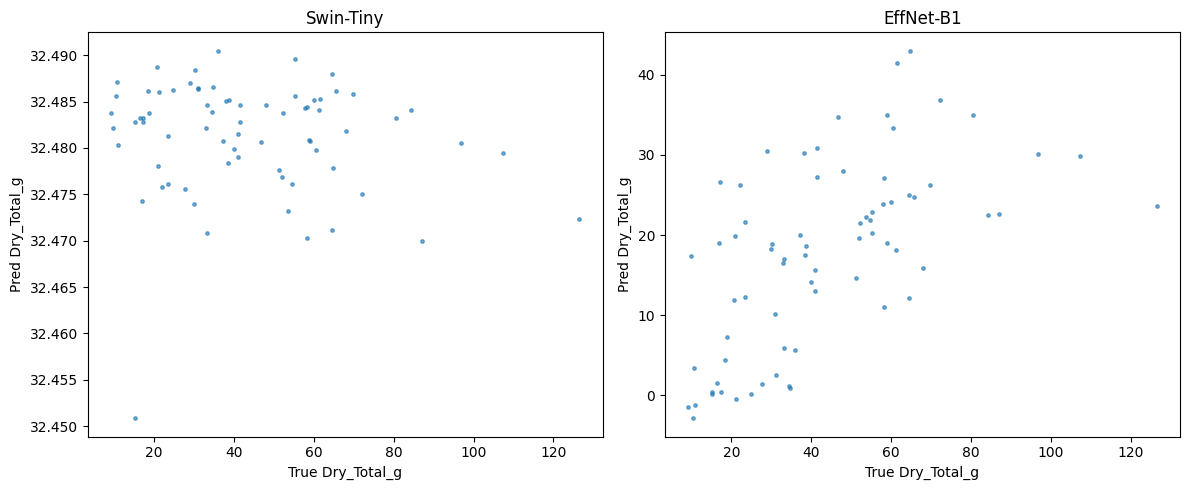

In [46]:

print_metrics("Swin-Tiny", targets_swin, preds_swin)
print_metrics("EffNet-B1", targets_b1, preds_b1)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(targets_swin[:,4], preds_swin[:,4], s=6, alpha=0.6)
plt.xlabel("True Dry_Total_g"); plt.ylabel("Pred Dry_Total_g"); plt.title("Swin-Tiny")

plt.subplot(1,2,2)
plt.scatter(targets_b1[:,4], preds_b1[:,4], s=6, alpha=0.6)
plt.xlabel("True Dry_Total_g"); plt.ylabel("Pred Dry_Total_g"); plt.title("EffNet-B1")
plt.tight_layout()
plt.show()
